In [1]:
import numpy as np #numerical computation
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
import seaborn as sns #a fancy plotting package
mpl.rcParams['figure.dpi'] = 400 #high res figures

# Necessary steps from previous exercises in this chapter

Note: adjust the path in the following cell to the location where you saved the cleaned data from Chapter 1.

In [2]:
df = pd.read_csv('../Data/Chapter_1_cleaned_data.csv')

Subset column list to features as in Chapter 3

In [3]:
features_response = df.columns.tolist()

In [4]:
features_response[:5]

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE']

In [5]:
features_response[-5:]

['EDUCATION_CAT', 'graduate school', 'high school', 'others', 'university']

In [6]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                   'PAY_6', 'EDUCATION_CAT', 'graduate school',
                   'high school', 'none','others', 'university']

In [7]:
features_response = [item for item in features_response
                     if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

In [9]:
from sklearn.model_selection import KFold
n_folds = 4
k_folds = KFold(n_splits=n_folds, shuffle=False)

# Activity 4: Cross-Validation and Feature Engineering with the Case Study Data

Subset out the features for the case study data

In [10]:
features = features_response[:-1]
features

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [11]:
len(features)

17

In [12]:
X = df[features].values

In [13]:
X.shape

(26664, 17)

Make a train/test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, df['default payment next month'].values,
test_size=0.2, random_state=24)

In [15]:
print(X_train.shape)
print(X_test.shape)

(21331, 17)
(5333, 17)


In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
min_max_sc = MinMaxScaler()

In [18]:
lr = LogisticRegression(solver='saga', penalty='l1', max_iter=1000)

In [19]:
lr

LogisticRegression(max_iter=1000, penalty='l1', solver='saga')

In [20]:
from sklearn.pipeline import Pipeline

In [21]:
scale_lr_pipeline = Pipeline(
    steps=[('scaler', min_max_sc), ('model', lr)])

In [22]:
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [23]:
scale_lr_pipeline.get_params()['model__C']

1.0

In [24]:
scale_lr_pipeline.set_params(model__C = 2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [25]:
C_val_exponents = np.linspace(2,-3,6)
C_val_exponents

array([ 2.,  1.,  0., -1., -2., -3.])

In [26]:
C_vals = np.float(10)**C_val_exponents
C_vals

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [27]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(pipeline.get_params()['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [28]:
%%time
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline,
                        X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001
CPU times: user 12.6 s, sys: 124 ms, total: 12.7 s
Wall time: 9.8 s


Text(0.5, 1.0, 'Cross validation on Case Study problem')

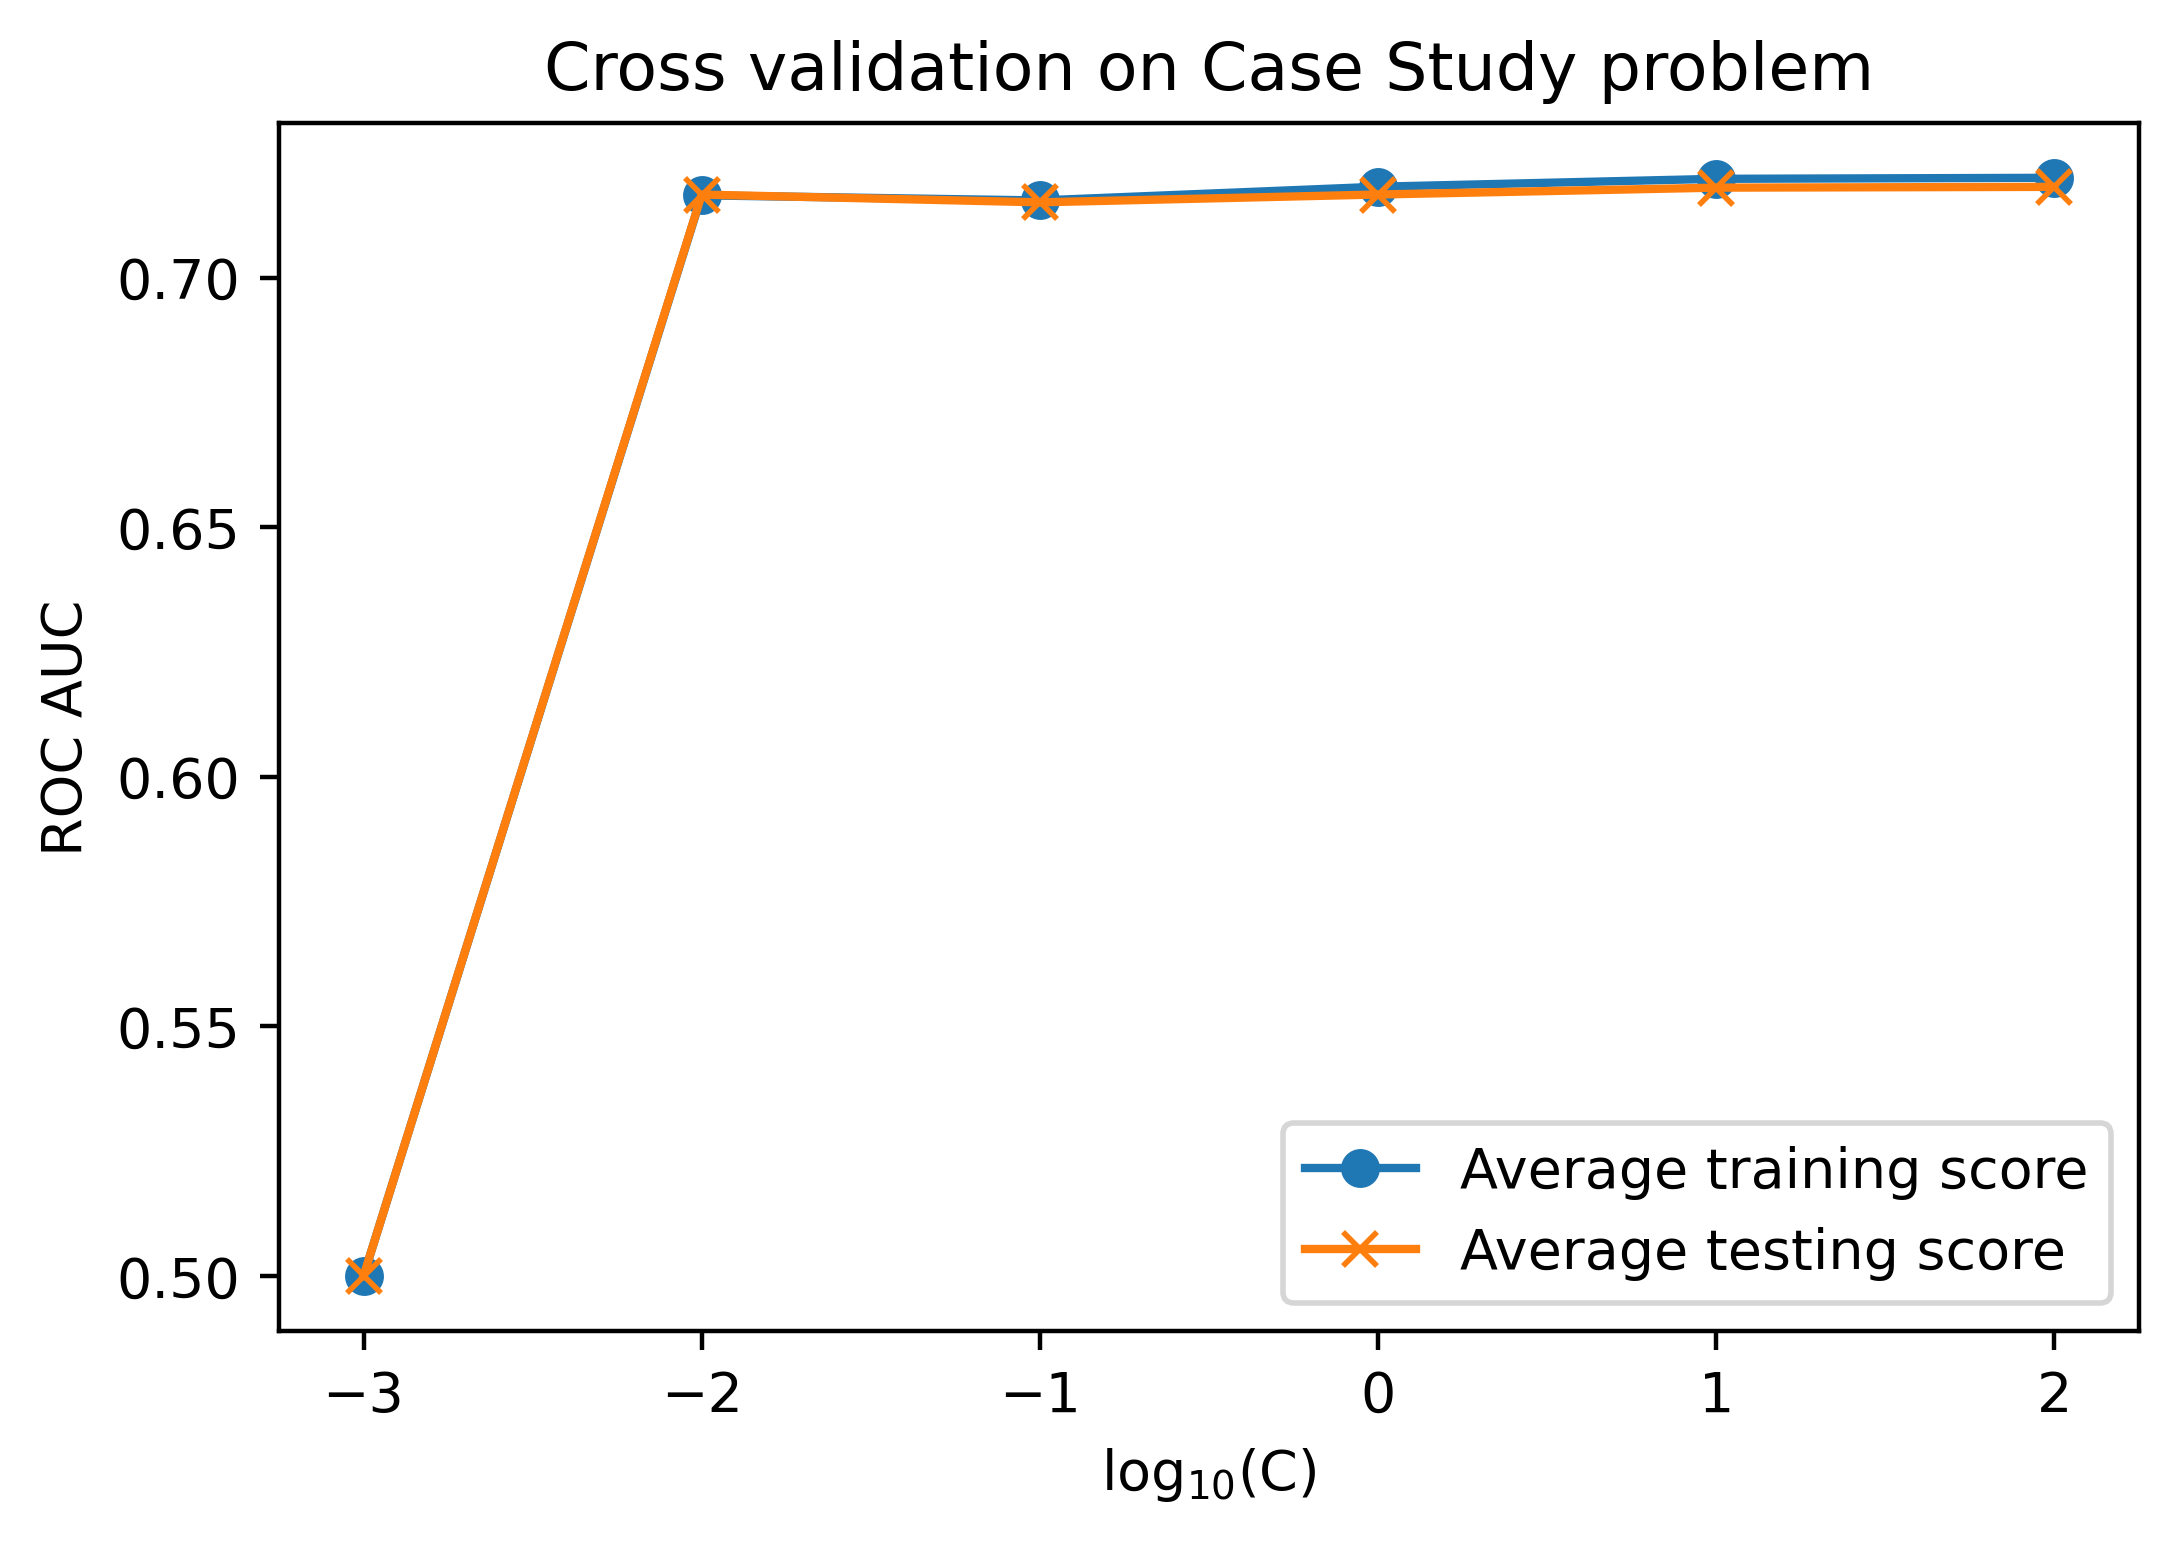

In [29]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation on Case Study problem')

In [30]:
np.mean(cv_test_roc_auc, axis=0)
# array([0.71816275, 0.71800641, 0.71662886, 0.71506499, 0.71661792,
#        0.5       ])

array([0.71816275, 0.71800641, 0.71662886, 0.71506499, 0.71661792,
       0.5       ])

Doesn't look like overfitting is happening. Our model may be underfitting. Let's try to engineer some new features to see if we can improve performance.

In [31]:
from sklearn.preprocessing import PolynomialFeatures

In [32]:
make_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interact = make_interactions.fit_transform(X)

In [33]:
X_interact.shape

(26664, 153)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
X_interact, df['default payment next month'].values,
test_size=0.2, random_state=24)

In [35]:
print(X_train.shape)
print(X_test.shape)

(21331, 153)
(5333, 153)


In [36]:
%%time
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

/Users/Steve/anaconda3/envs/dspwp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Steve/anaconda3/envs/dspwp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Steve/anaconda3/envs/dspwp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Steve/anaconda3/envs/dspwp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with C = 100.0


/Users/Steve/anaconda3/envs/dspwp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Steve/anaconda3/envs/dspwp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Steve/anaconda3/envs/dspwp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Steve/anaconda3/envs/dspwp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with C = 10.0


/Users/Steve/anaconda3/envs/dspwp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Steve/anaconda3/envs/dspwp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Steve/anaconda3/envs/dspwp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001
CPU times: user 7min 1s, sys: 2.57 s, total: 7min 4s
Wall time: 7min 27s


Text(0.5, 1.0, 'Cross validation on Case Study problem')

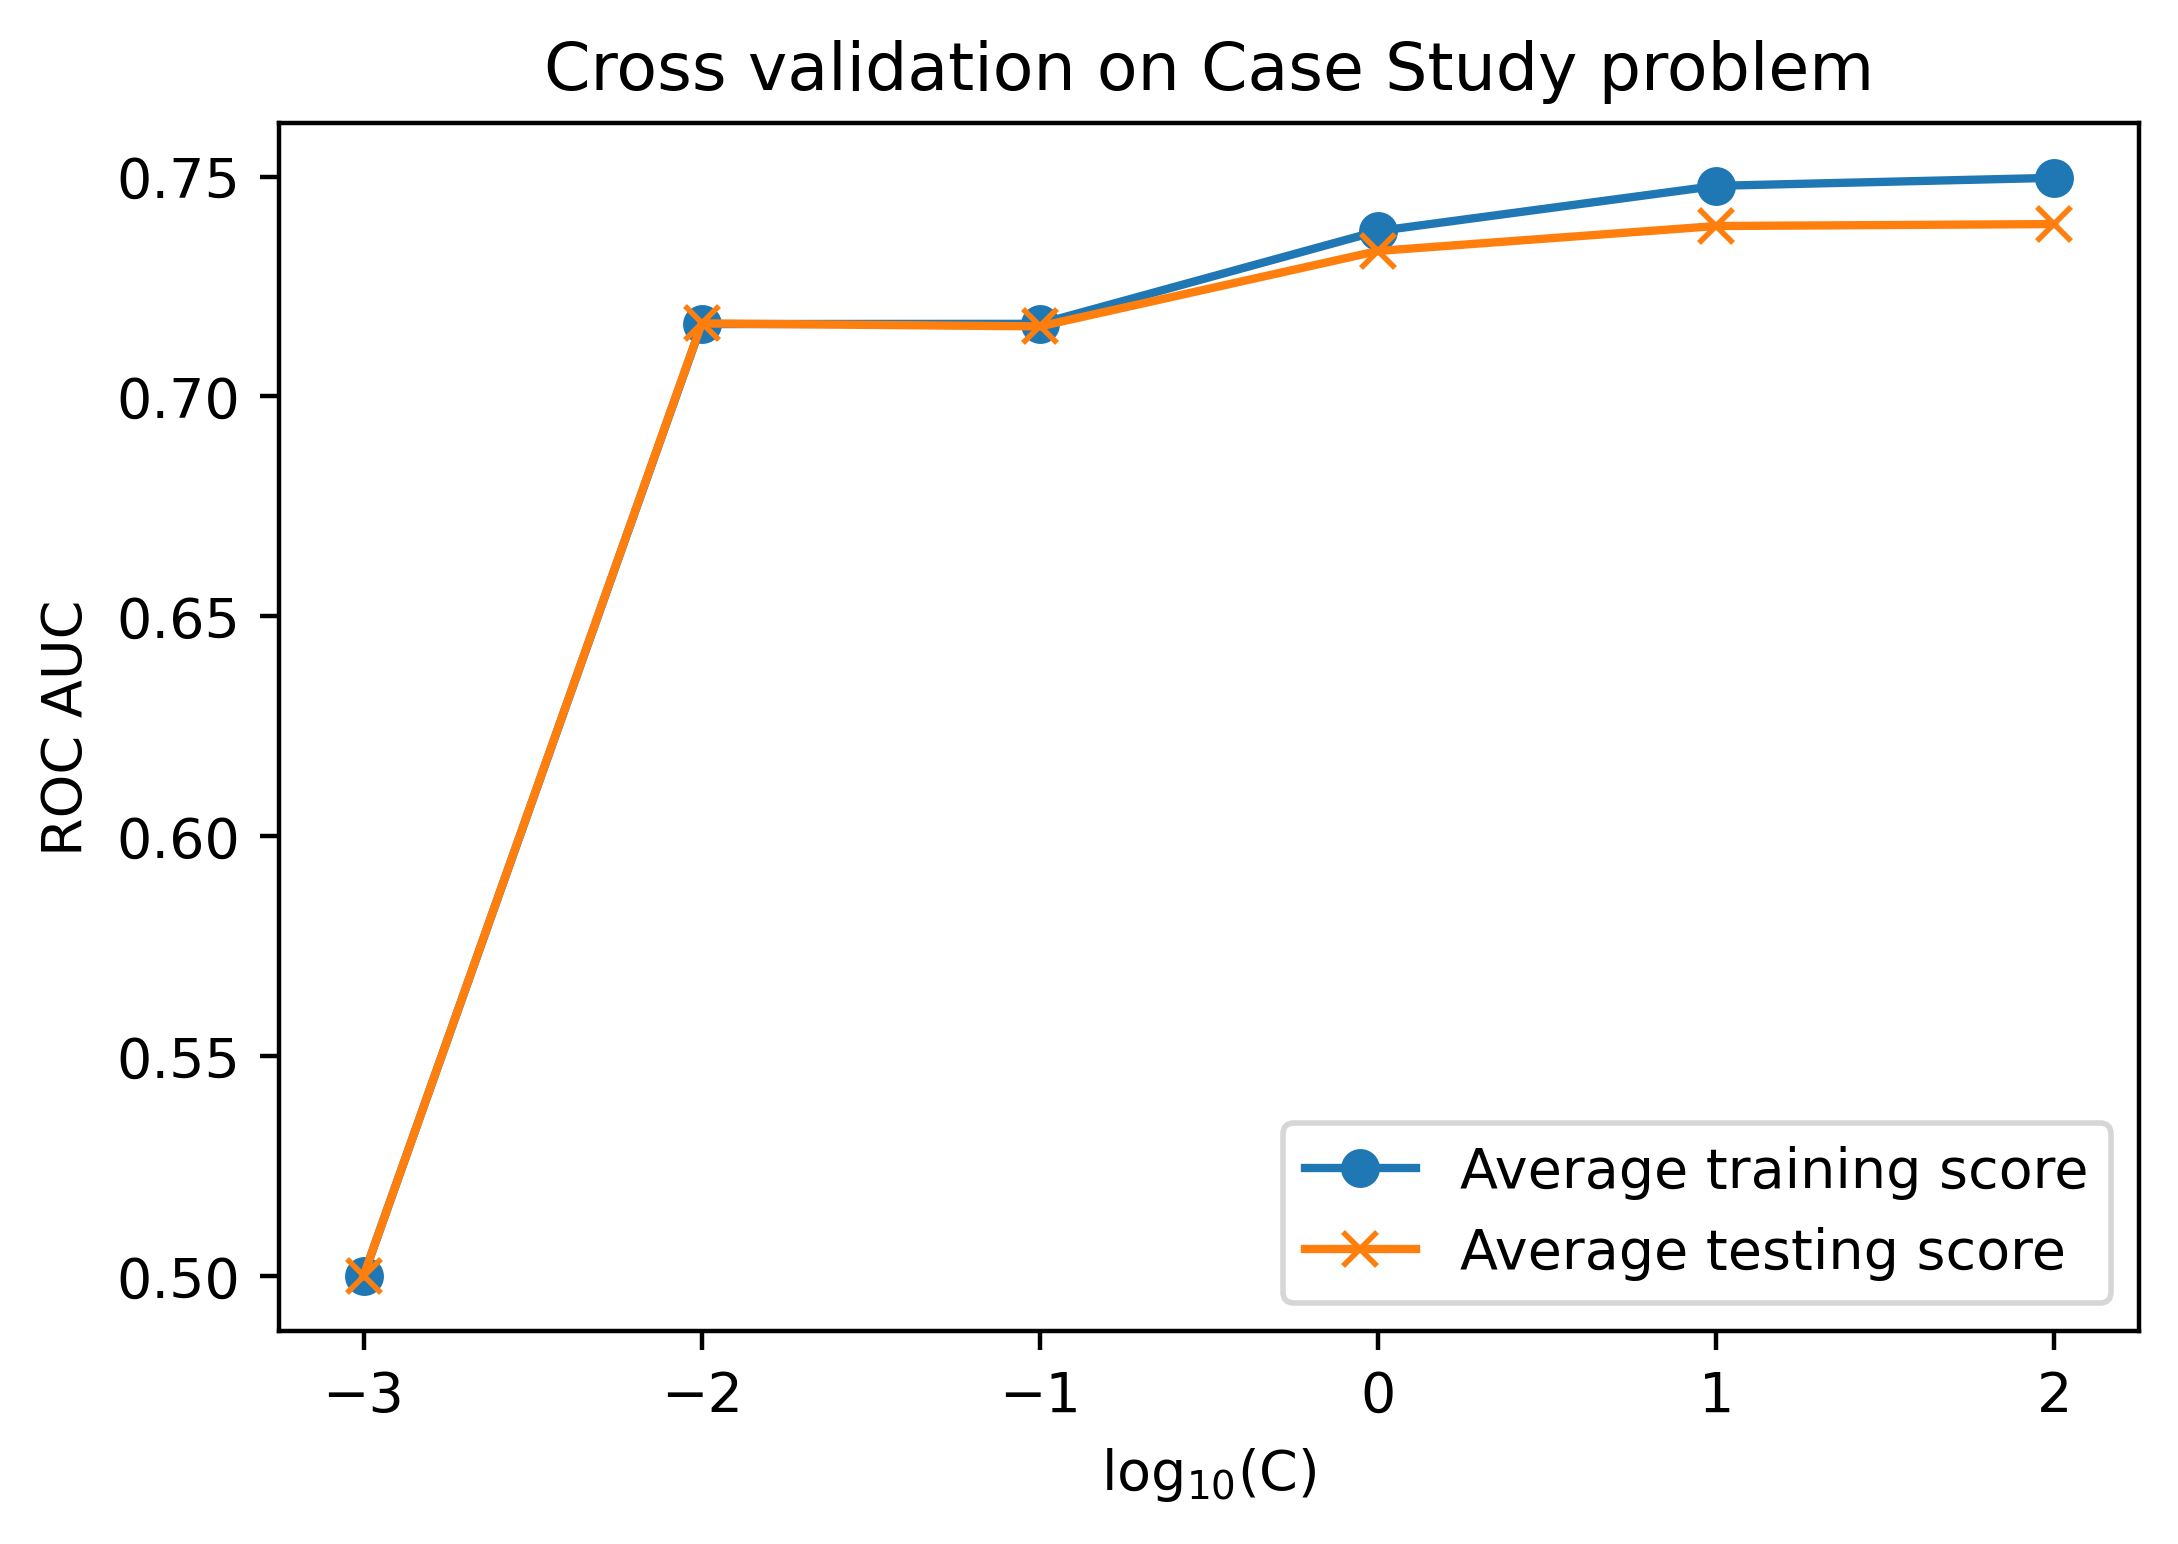

In [37]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation on Case Study problem')

In [38]:
np.mean(cv_test_roc_auc, axis=0)
# array([0.73920673, 0.73876206, 0.73309472, 0.71594021, 0.71661792,
#        0.5       ])

array([0.73920673, 0.73876206, 0.73309472, 0.71594021, 0.71661792,
       0.5       ])